# Robust Regression with PyMC3

In statistics there are two approaches to modeling.  The first is known as the frequentist approach which is what master's and PhD level statistics majors often study first.  This is the classic statistical thinking where point estimates (often the estimates that maximize the likelihood function) are used to estimate distributions and inferences can be done about these estimates.  This project will use the other statistical methodology to modeling known as the Bayesian approach where instead of estimating parameters with point estimates from a sample, parameters are treated as random variables with distributions themselves.  

This project will demonstrate fitting GLMs using the bayesian methodology with the PyMC3 package and examine the effect of outliers on a linear regression; as well as using robust regression as a way to handle the common issue of outliers in training data.  The last point made will demonstrate the advantage of using bayesian model fitting as opposed to the standard frequentist approach.

In [1]:
# pandas and numpy for data manipulation
import pandas as pd
import numpy as np
import arviz as az
from scipy import stats

# pymc3 for Bayesian Inference, pymc built on t
import pymc3 as pm

# matplotlib for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib
import seaborn as sns

sns.set_theme(style="darkgrid")

## Brief Intro to Bayesian vs. Frequentist Approach to Regression

In the simplest terms, the biggest difference between the Bayesian and Frequentist approach to regression are the parameter estimation assumptions.  In the Frequentist approach, the assumption is the for target variable $y$ and $p$ independent predictors $x_{i}$: $$ y \sim N(\mu=\beta_{0}+\sum_{i=1}^{p}\beta_{i}x_{i},  \sigma^2) $$

This insinuates that there are two values of the parameters $\beta_0$ ... $\beta_p$ and then the goal is to estimate them by minimizing the squared error loss or maximizing the normal likelihood function.  

In the Bayesian approach, the assumption is that there is no true values for $\beta_0$ ... $\beta_p$ but that each of those are a random variable themselves.  This brings that the distribution of $y$ is now dependent on the values of $\beta_0$ ... $\beta_p$.  The simulate example below will make this much more clear.

## Generating Example Data

Below two random variables x and y as well as a linear relationship between them defined by b0 (intercept), b1 (slope), and sigma (noise not explained by the relationship between x and y).  The data is generated as follows:

$$x \sim N(\mu = 5, \sigma^2=3)$$
$$b_0 \sim N(\mu = 5, \sigma^2=1)$$
$$b_1 \sim N(\mu=10, \sigma^2=1)$$
$$y \sim ~ N(\mu = b_0 + b_1*x, \sigma^2 = 25)$$

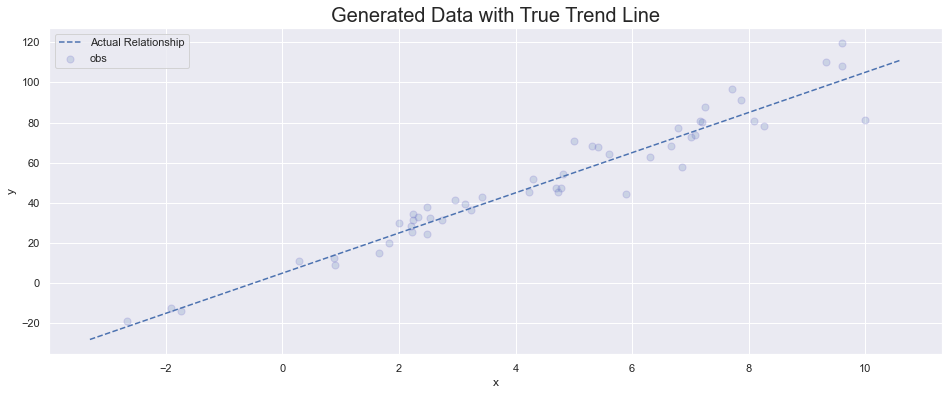

In [2]:
b0_mean = 5
b1_mean = 10

x = np.random.normal(5, 3, 50)
b0 = np.random.normal(b0_mean, 1, 50)
b1 = np.random.normal(b1_mean, 1, 50)
sigma = 25**.5

y = np.random.normal(b0 + b1 * x, sigma)

df = pd.DataFrame({'y': y, 'x': x})

figsize(16, 6)

# plt.plot(x, y, color = 'navy', 
#          lw=3, label="Most Likely Logistic Model")
plt.scatter(x, y, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.ylabel('y')
plt.xlabel('x')

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = b0_mean + b1_mean * x_vals
plt.plot(x_vals, y_vals, '--', label="Actual Relationship")
plt.title("Generated Data with True Trend Line", fontsize=20)
plt.legend()

plt.show()

## Fitting the Normal Distribution GLM

The code below uses the NUTS sampler algorithm in the PyMC3 library to fit the normal distribution GLM (this is a standard linear regression) using the Bayesian methodology.  The syntax first declares distributions for the priors of the model parameters, then it uses the actual data to create the posterior distribution of the model.  

Printed out 

/var/folders/d3/l1h2w3dj6m9cnl162jqdffzm0000gn/T/ipykernel_58153/3716620112.py:15: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  model_trace = pm.sample(n_iterations, tune=5000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 5_000 tune and 2_000 draw iterations (20_000 + 8_000 draws total) took 15 seconds.


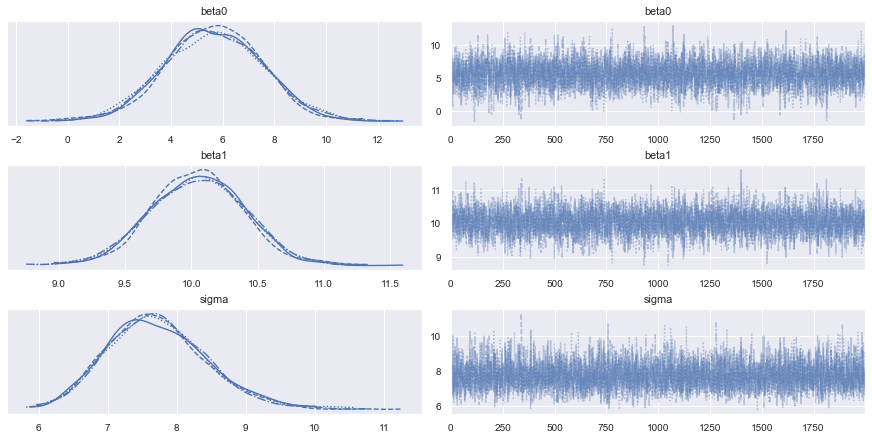

In [3]:
n_iterations = 2000
with pm.Model() as model:

    # Define the priors of the model
    beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)
    sigma = pm.Exponential('sigma', 1)
    
    # 
    mu = beta0 + beta1 * x
    # Create the probability from the logistic function
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior using the sampling method
    model_trace = pm.sample(n_iterations, tune=5000)
    pm.plot_trace(model_trace)

We can see from the trace above that the true average for each parameter estimated has high density in each respective distribution ($\mu_{b_0}=5 and \mu_{b_1}=10$); and for predictions we can use these values to compare the model fit to the true relationship.

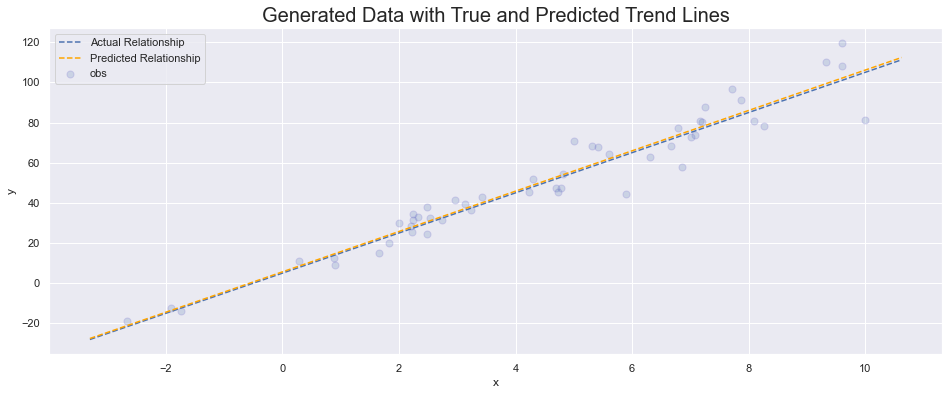

In [4]:
# Averages of each respective parameter estimate
b0_est1 = model_trace["beta0"].mean()
b1_est1 = model_trace["beta1"].mean()

figsize(16, 6)

plt.scatter(x, y, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.ylabel('y')
plt.xlabel('x')

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = b0_mean + b1_mean * x_vals
y_pred = b0_est1 + b1_est1 * x_vals

plt.plot(x_vals, y_vals, '--', label="Actual Relationship")
plt.plot(x_vals, y_pred, '--', label="Predicted Relationship", color="orange")

plt.title("Generated Data with True and Predicted Trend Lines", fontsize=20)
plt.legend()

plt.show()

The model is practically overlapping the true best fit line and appears to fit the data very well!


## Robust Regression (Model using the Student's t distribution rather than the Normal)

As stated in the beginning of this tutorial, on big assumption of this type of statistical modeling is that the response, $y$, is perfectly normally distributed given the linear combination of the vector $x$ and the parameters $\beta_{0}$ ... $\beta_{p}$.  In theory this is great for inference and model fitting but in practice this assumption may not always work out.  

One common issue in the world of data science is the prescence outliers present in the data.  Although there are statistical methods to help identify outliers such as observing unusually large residuals in a halfnormal plot or analyzing the jackknife residuals, often times removing these outliers one by one can cause issues (such as removing one outlier creates another). One method that can be used to model the normal distribution is known as a Robust Regression.  

As the name entails the Robust Regression technique is one which is robust to outliers and such can accurately estimate the parameter estimates of a regression in the presence of outliers where a normal linear regression is highly susceptible to outliers.  The way it does this is using modeling the response as a Student's t distribution rather than a Normal distribution.  The nature of the "fatter" tails of the Student's t distribution allow it to limit the affect of outliers on it's parameter estimates where the Normal model will drastically change to accomodate the prescence of the outliers.

To demonstrate this advantage of the Student's t distribution we can re-do our analysis with some synthetic outliers added to our data.

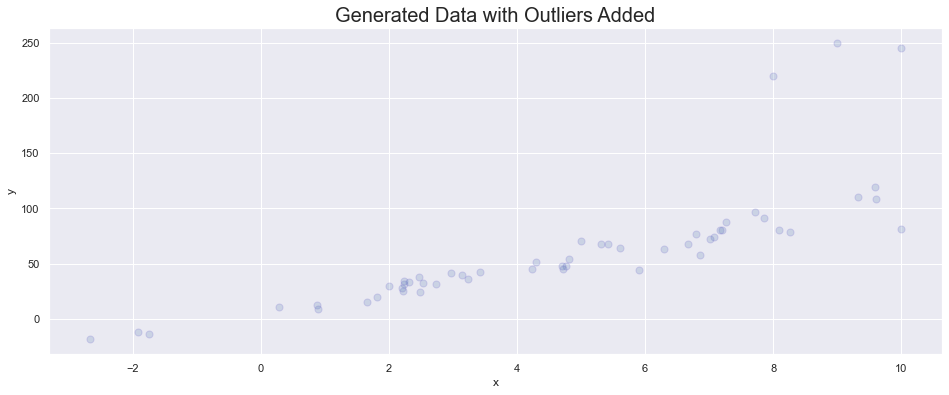

In [5]:
## adding outliers
x = np.append(x, [8, 9, 10])
y = np.append(y, [220, 250, 245])


df = pd.DataFrame({'y': y, 'x': x})

figsize(16, 6)

# plt.plot(x, y, color = 'navy', 
#          lw=3, label="Most Likely Logistic Model")
plt.scatter(x, y, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.title("Generated Data with Outliers Added", fontsize=20)
plt.ylabel('y')
plt.xlabel('x')

plt.show()

Now with these outliers added to our data, we can rerun the Normal model and the equivalent Robust Regression model.

/var/folders/d3/l1h2w3dj6m9cnl162jqdffzm0000gn/T/ipykernel_58153/2175905022.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  model_trace = pm.sample(n_iterations, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


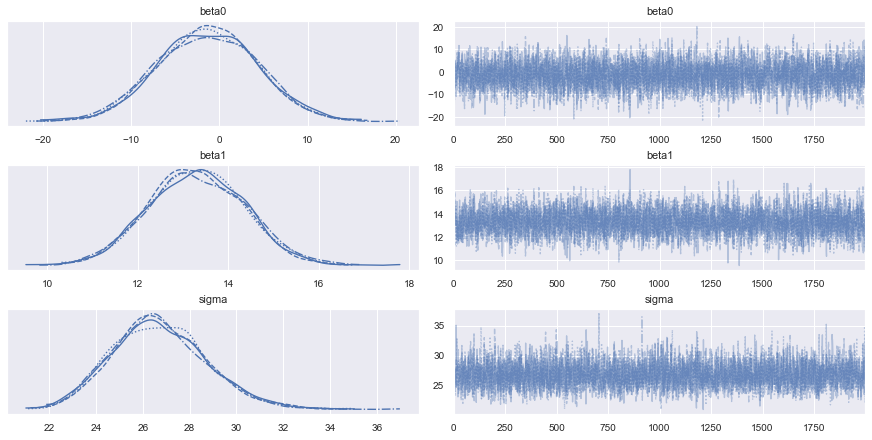

In [6]:
# Rerun normal model with new data including outliers
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)
    sigma = pm.Exponential('sigma', 1)
    
    mu = beta0 + beta1 * x
    # Create the probability from the logistic function
    obs = pm.Normal("obs", mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior using the sampling method
    model_trace = pm.sample(n_iterations, tune=1000)
    pm.plot_trace(model_trace)

/var/folders/d3/l1h2w3dj6m9cnl162jqdffzm0000gn/T/ipykernel_58153/1150386730.py:13: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  robust_model_trace = pm.sample(n_iterations, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8864687789924035, but should be close to 0.8. Try to increase the number of tuning steps.


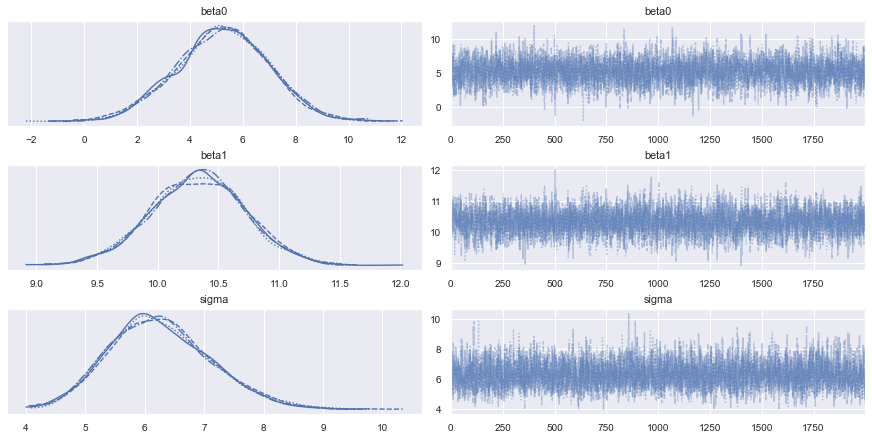

In [7]:
# Run the Robust regression model
with pm.Model() as model:
    beta0 = pm.Normal('beta0', mu=0.0, tau=0.01, testval=0.0)
    beta1 = pm.Normal('beta1', mu=0.0, tau=0.01, testval=0.0)
    sigma = pm.Exponential('sigma', 1)
    nu = 3
    
    mu = beta0 + beta1 * x
    # Create the probability from the logistic function
    obs = pm.StudentT("obs", nu=nu, mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior using the sampling method
    robust_model_trace = pm.sample(n_iterations, tune=1000)
    pm.plot_trace(robust_model_trace)

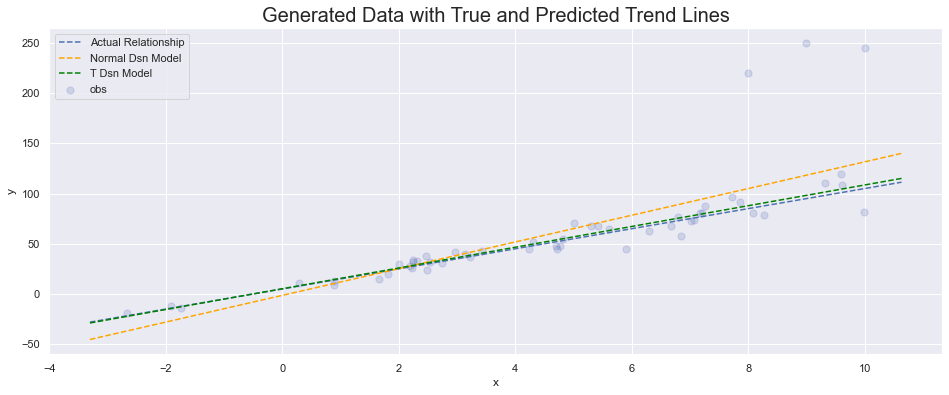

In [8]:
b0_est1 = model_trace["beta0"].mean()
b1_est1 = model_trace["beta1"].mean()

b0_est2 = robust_model_trace["beta0"].mean()
b1_est2 = robust_model_trace["beta1"].mean()

figsize(16, 6)

# plt.plot(x, y, color = 'navy', 
#          lw=3, label="Most Likely Logistic Model")
plt.scatter(x, y, edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.ylabel('y')
plt.xlabel('x')

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = b0_mean + b1_mean * x_vals
y_pred = b0_est1 + b1_est1 * x_vals
y_pred_robust = b0_est2 + b1_est2 * x_vals

plt.plot(x_vals, y_vals, '--', label="Actual Relationship")
plt.plot(x_vals, y_pred, '--', label="Normal Dsn Model", color="orange")
plt.plot(x_vals, y_pred_robust, '--', label="T Dsn Model", color="green")

plt.title("Generated Data with True and Predicted Trend Lines", fontsize=20)
plt.legend()

plt.show()

It is clear from chart above the the Normal Distribution model (yellow) is severely impacted by the outliers as the slope is increased, dragging the predictions with it!  However, the Student's t distribution model (green) is hardly impacted at all and proves to, in fact, be very robust to these outliers in the data - the model is just about overlapping with the actual best fit line!

## Model Updates

One big advantage to using Bayesian modeling is the ability to update the model easily.  For each new model, instead of starting over with non-informative or less-informative priors as in the first iteration of the model the posterior distribution of all of the parameters from the last iteration of the model can be used.  

For example, let's say that after fitting and comparing our Normal and Student's t distribution models on our first 50 data points we decide that we would like to go with the Student's t model.  Now a couple weeks down the road you have received some more data points and would like to update or refit your model.  With a typical machine learning predictive model, you would have to make the decision to either us all or some of the data from the last model fitting plus the new data made available.  Using Bayesian modeling such as this, you can merely save the samples from the posterior of the last model fitting and use them as the prior for the same parameters for this updated version of the model!

In [9]:
# This function allows us to sample from the respective posteriors of the parameters from the last iteration of the 
# model as the priors for this new iteration of the model
def from_posterior(param, samples):
    smin, smax = np.min(samples), np.max(samples)
    width = smax - smin
    x = np.linspace(smin, smax, 100)
    y = stats.gaussian_kde(samples)(x)

    # what was never sampled should have a small probability but not 0,
    # so we'll extend the domain and use linear approximation of density on it
    x = np.concatenate([[x[0] - 3 * width], x, [x[-1] + 3 * width]])
    y = np.concatenate([[0], y, [0]])
    return pm.Interpolated(param, x, y)

In [10]:
full_traces = [robust_model_trace]

/var/folders/d3/l1h2w3dj6m9cnl162jqdffzm0000gn/T/ipykernel_58153/342131209.py:17: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  update_robust_model_trace = pm.sample(n_iterations, tune=1000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta1, beta0]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 12 seconds.


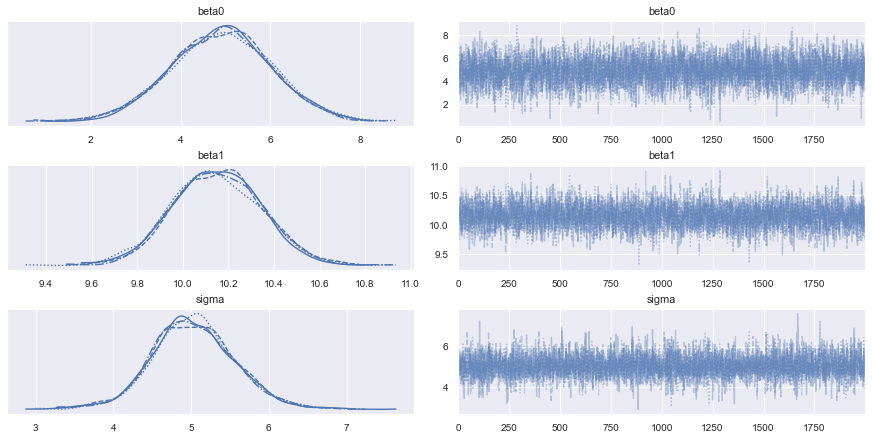

In [11]:
x_next = np.random.normal(5, 3, 50)
y_next = np.random.normal(5 + 10 * x_next, 5)

with pm.Model() as update_model:
    # Priors are posteriors from previous iteration
    b0_update = from_posterior("beta0", robust_model_trace["beta0"])
    b1_update = from_posterior("beta1", robust_model_trace["beta1"])
    sigma = from_posterior("sigma", robust_model_trace["sigma"])

    # Expected value of outcome
    mu = b0_update + b1_update * x_next

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.StudentT("Y_obs", nu = 3, mu=mu, sigma=sigma, observed=y_next)

    # draw 10000 posterior samples
    update_robust_model_trace = pm.sample(n_iterations, tune=1000)
    full_traces.append(update_robust_model_trace)
    pm.plot_trace(update_robust_model_trace)

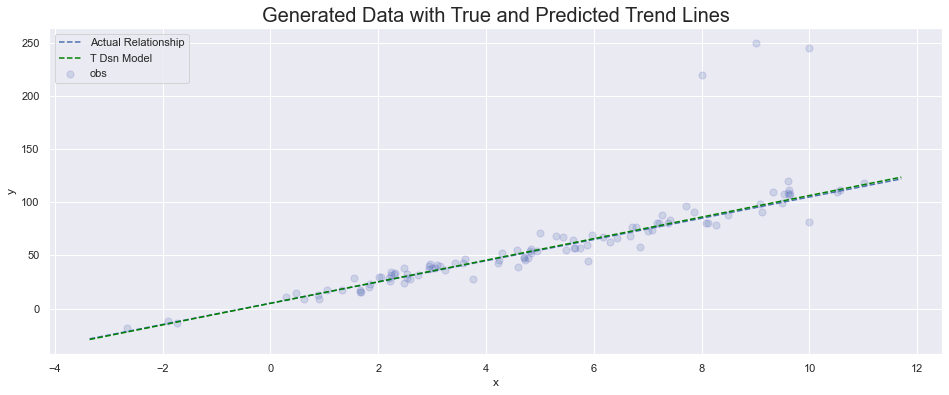

In [12]:
b0_update = update_robust_model_trace["beta0"].mean()
b1_update = update_robust_model_trace["beta1"].mean()

figsize(16, 6)

# plt.plot(x, y, color = 'navy', 
#          lw=3, label="Most Likely Logistic Model")
plt.scatter(np.append(x, x_next), np.append(y, y_next), edgecolor = 'slateblue',
            s=50, alpha=0.2, label='obs')
plt.ylabel('y')
plt.xlabel('x')

axes = plt.gca()
x_vals = np.array(axes.get_xlim())
y_vals = b0_mean + b1_mean * x_vals
y_pred_robust = b0_update + b1_update * x_vals

plt.plot(x_vals, y_vals, '--', label="Actual Relationship")
plt.plot(x_vals, y_pred_robust, '--', label="T Dsn Model", color="green")

plt.title("Generated Data with True and Predicted Trend Lines", fontsize=20)
plt.legend()

plt.show()

Now we have used all of our data for our model while only rerunning the model on the new data!